In [1]:
%load_ext autoreload
%autoreload 2

# System imports
from dataclasses import dataclass
from typing import NamedTuple, Callable, Optional
import time

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi
import optax

# Local imports
import loss
import dataset
from model import VGAE, VGAEOutput
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
RNG_KEY = jax.random.PRNGKey(3)

In [3]:
IMAGE_SHAPE = (15, 10)

(
    A, D, d, 
    num_regions, 
    (num_x, num_y),
) = dataset.generate_synthetic_dataset(IMAGE_SHAPE[0], IMAGE_SHAPE[1])

np.linalg.det(np.linalg.inv(D - A))

0.0

In [4]:
from typing import Dict

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  decoder_params: Optional[Params] = None
  scaler: Optional[callable] = None
  
CAR_ARGS = CARArgs()

In [5]:
def car_predictive_model(args: CARArgs) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)

  alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

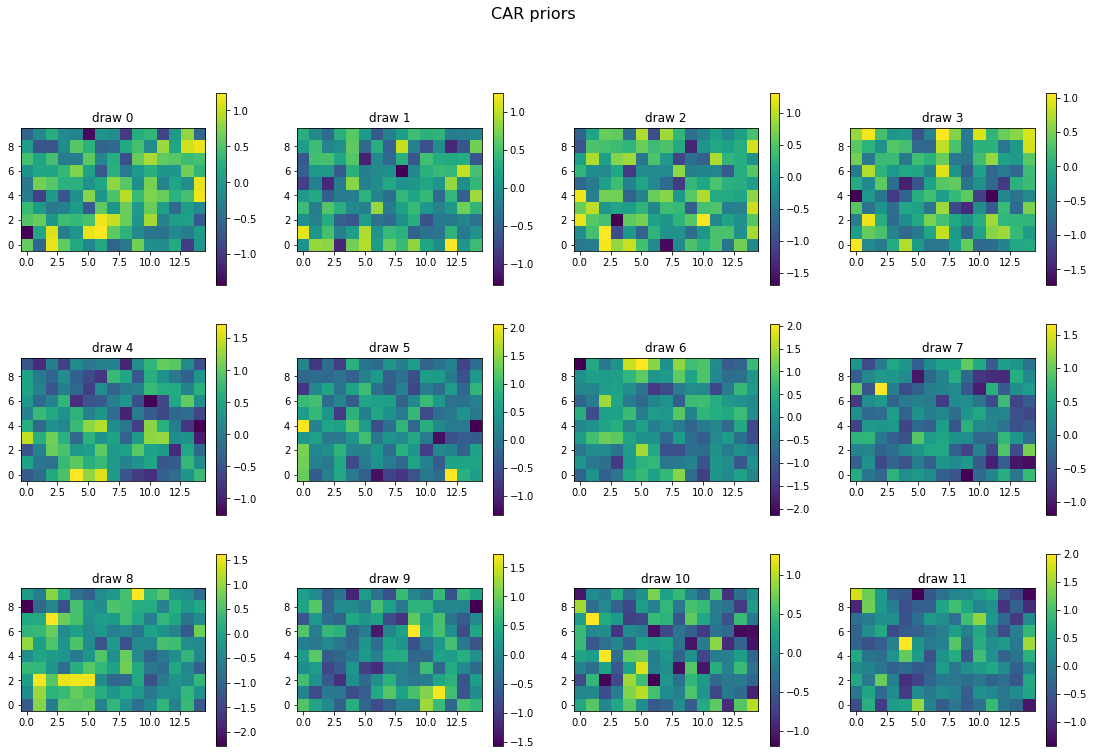

In [6]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_preds = Predictive(car_predictive_model, num_samples=100)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

plotting.plot_samples(car_draws, image_shape=IMAGE_SHAPE)

In [7]:
def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car']  # (batch_size, num_regions)
    return car_draws

def generate_graph_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 32,
        model_args: CARArgs = CAR_ARGS) -> jraph.GraphsTuple:
    car_draws = generate_car_batch(rng, batch_size, model_args)
    graphs = [
        dataset.get_car_draws_as_graph(draw.reshape(-1, 1), A) 
            for draw in car_draws
    ]
    return jraph.batch(graphs)

I should expect larger `scale` to have better performance on the decoder as now the KL-divergence is imposed correctly?

In [8]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun = loss.compute_mse_loss
  num_nodes: int = A.shape[0]  
  batch_size: int = 1
  scale: int = 20.0
  
  act_fn = jax.nn.leaky_relu
  hidden_dim: int = 40
  latent_dim: int = 5
  output_dim: int = 1
  
  learning_rate: float = 1e-4
  epochs: int = 500_000
  
  eval_frequency: int = 10_000
  
ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x15ace2d30>, num_nodes=150, batch_size=1, scale=20.0, hidden_dim=40, latent_dim=5, output_dim=1, learning_rate=0.0001, epochs=500000, eval_frequency=10000)


In [9]:
from pathlib import Path
train_path = Path.cwd() / 'dataset/synthetic_car_train_data_WIDERALPHA.npy'
val_path = Path.cwd() / 'dataset/synthetic_car_val_data_WIDERALPHA.npy'

RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)
if train_path.exists() and val_path.exists():
    train_data = jnp.array(np.load(train_path))
    val_data = jnp.array(np.load(val_path))
else:
    train_data = generate_car_batch(train_rng, batch_size=ARGS.epochs)
    val_data = generate_car_batch(val_rng, batch_size=ARGS.epochs)
    np.save(train_path, np.asarray(train_data))
    np.save(val_path, np.asarray(val_data))

In [10]:
class NoScaler:
    def __init__(self):
        return
    def fit(self, x):
        pass
    def fit_transform(self, x):
        return self.transform(x)
    def transform(self, x):
        return np.array(x)
    def inverse_transform(self, x):
        return np.array(x)
    
class LinearScaler:
    def __init__(self, scale: int = 1.0):
        self.scale = scale
        
    def fit(self, x):
        pass
    def fit_transform(self, x):
        return self.transform(x)
    def transform(self, x):
        return self.scale * np.array(x)
    def inverse_transform(self, x):
        return 1.0/self.scale * np.array(x)

In [11]:
scaler = LinearScaler(scale=ARGS.scale)
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

base_graph = dataset.create_grid_graph(A)
scaled_graph_train_data = [
    base_graph._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_train_data
]
scaled_graph_val_data = [
    base_graph._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_val_data
]

CAR_ARGS.scaler = scaler

In [12]:
def rescale_nodes(nodes: jnp.ndarray):
    return scaler.inverse_transform(nodes.reshape(1, -1))

# # Unscaling process
# unscaled_train_data = [rescale_nodes(g.nodes) for g in scaled_graph_train_data]
# unscaled_val_data = [rescale_nodes(g.nodes) for g in scaled_graph_val_data]

In [13]:
from functools import partial
from typing import Tuple

import layer

def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
        del edges
        x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
        return hk.Linear(1)(x)

def _attention_logit_fn_with_name(
    sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
    edges: jnp.ndarray, name: str) -> jnp.ndarray:
        del edges
        x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
        return hk.Linear(1, name=name)(x)

def encoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        latent_dim: int,
        act_fn: Callable = jax.nn.leaky_relu
    ) -> Tuple[jraph.GraphsTuple, jraph.GraphsTuple]:
    
    gn = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Sequential([
            hk.Linear(hidden_dim), act_fn,
        ]),
    )
    graph = gn(graph)
    
    # No activation
    gn_mean = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Linear(latent_dim),
    )
    gn_log_std = layer.GAT(
        attention_query_fn=hk.Linear(10),
        attention_logit_fn=_attention_logit_fn,
        node_update_fn=hk.Linear(latent_dim),
    )
    
    mean_graph, log_std_graph = gn_mean(graph), gn_log_std(graph)
    return mean_graph, log_std_graph


def decoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        output_dim: int,
        act_fn: Callable = jax.nn.leaky_relu) -> jraph.GraphsTuple:
    
    gn = layer.GAT(
        attention_query_fn=hk.Linear(10, name='decoder_hidden_attention_query_fn'),
        attention_logit_fn=partial(_attention_logit_fn_with_name, 
                                   name='decoder_hidden_attention_logit_fn'),
        node_update_fn=hk.Sequential([
            hk.Linear(hidden_dim, name='decoder_hidden'), act_fn,
            ]),
    )
    graph = gn(graph)
    
    # No activation
    gn = layer.GAT(
        attention_query_fn=hk.Linear(10, name='decoder_output_attention_query_fn'),
        attention_logit_fn=partial(_attention_logit_fn_with_name, 
                                   name='decoder_output_attention_logit_fn'),
        node_update_fn=hk.Linear(output_dim, name='decoder_output'),
    )
    graph = gn(graph)

    return graph


class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_dim,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean_graph, log_std_graph = encoder(
            graph,
            self._hidden_dim,
            self._latent_dim,
        )
        mean, log_std = mean_graph.nodes, log_std_graph.nodes
        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)
        z_graph = mean_graph._replace(nodes=z)
        output = decoder(
            z_graph,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, log_std, output)

In [14]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=ARGS.hidden_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim)(x))

optimizer = optax.adam(ARGS.learning_rate)

# scheduler = optax.exponential_decay(
#     init_value=ARGS.learning_rate,
#     transition_steps=1000,
#     decay_rate=0.99,
# )

# # Combining gradient transforms using `optax.chain`
# optimizer = optax.chain(
#     optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
# )

In [15]:
from model import VGAEOutput

@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  
  return -elbo
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [16]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = scaled_graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [17]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = scaled_graph_train_data[epoch]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = scaled_graph_val_data[epoch]
    val_loss = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
      
    train_losses.append(train_loss)
    val_losses.append(val_loss)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x15ace2d30>
17:34:05 STEP: 0; Train loss: 16035.916; Validation loss: 233236.000
17:34:11 STEP: 10000; Train loss: 150.998; Validation loss: 2959.019
17:34:16 STEP: 20000; Train loss: 84.210; Validation loss: 111.854
17:34:22 STEP: 30000; Train loss: 65.758; Validation loss: 58.587
17:34:27 STEP: 40000; Train loss: 61.766; Validation loss: 59.334
17:34:33 STEP: 50000; Train loss: 66.005; Validation loss: 51.546
17:34:38 STEP: 60000; Train loss: 87.489; Validation loss: 59.055
17:34:44 STEP: 70000; Train loss: 41.013; Validation loss: 59.846
17:34:49 STEP: 80000; Train loss: 64.611; Validation loss: 60.591
17:34:55 STEP: 90000; Train loss: 43.666; Validation loss: 69.503
17:35:01 STEP: 100000; Train loss: 65.582; Validation loss: 69.619
17:35:07 STEP: 110000; Train loss: 49.160; Validation loss: 63.917
17:35:13 STEP: 120000; Train loss: 69.225; Validation loss: 77.103
17:35:19 STEP: 130000; Train loss: 65.239; Validation loss: 63.002
17:35:25 STEP:

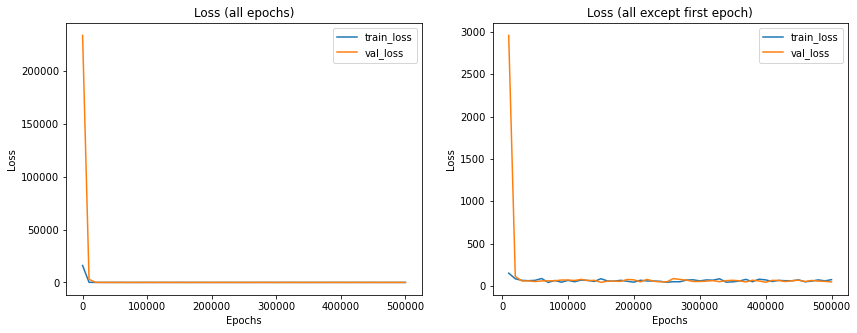

In [18]:
from matplotlib.ticker import MaxNLocator

_, axes = plt.subplots(1, 2, figsize=(14, 5))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0].plot(xs, train_losses, label='train_loss')
axes[0].plot(xs, val_losses, label='val_loss')
axes[1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0].set_title('Loss (all epochs)')
axes[1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[i].set_ylabel('Loss')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
plt.show()

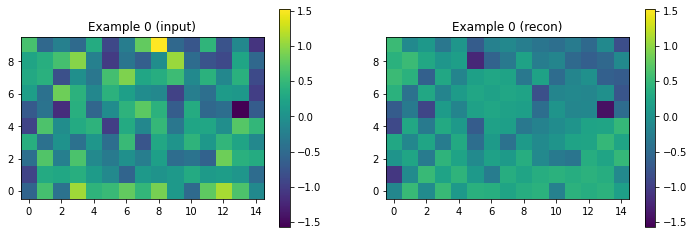

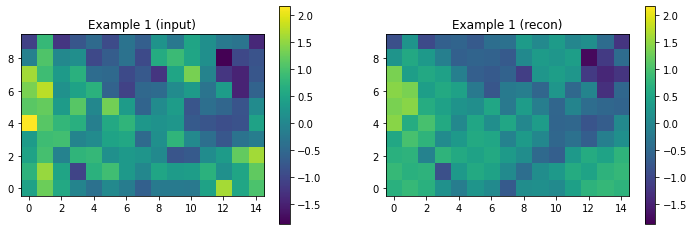

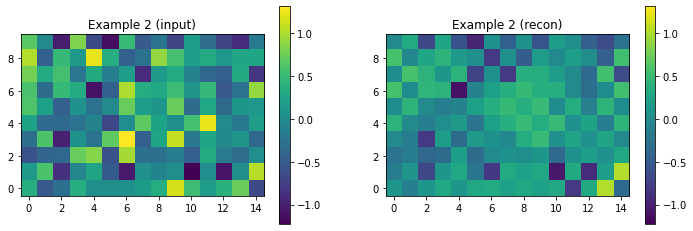

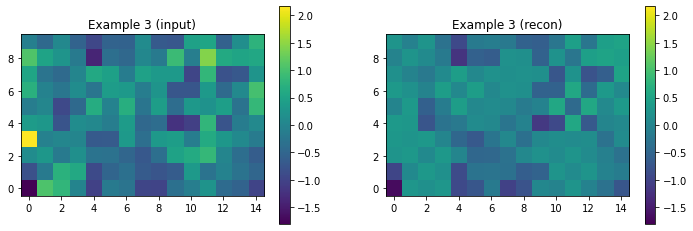

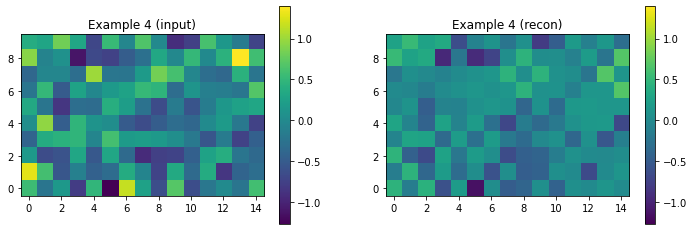

In [19]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    original_data = val_data[i]
    scaled_data_graph = scaled_graph_val_data[i]
    outputs = net.apply(params, RNG_KEY, scaled_data_graph)
    
    # Unscaling
    recon_data = scaler.inverse_transform(jnp.ravel(outputs.output.nodes))

    original_image = jnp.ravel(original_data)
    recon_image = jnp.ravel(recon_data)

    ax, _ = plotting.plot_images_from_arrays(
        arrays=[original_image, recon_image],
        titles=['input', 'recon'],
        image_shape=IMAGE_SHAPE,
    )
    
    ax[0].set_title(f'Example {i} (input)')
    ax[1].set_title(f'Example {i} (recon)')

In [20]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x15ace2d30>, num_nodes=150, batch_size=1, scale=20.0, hidden_dim=40, latent_dim=5, output_dim=1, learning_rate=0.0001, epochs=500000, eval_frequency=10000)


WHAT I DID: 

- 30/7 00:32: Removed node_update_fn in first GAT layer
- 30/7 00:38: Removed 10**3 factor in loss function
- 30/7 12:52: Remove activation in the last encoder layers (mean, std)
- 30/7 12:57: Added self edges to all GAT layers (including no activation ones)
- 30/7 13:05: Added 10**2 factor in loss function (to see self edges + good learning)
- 30/7 13:14: Remove self edges from final GAT layers (in both encoder and decoder)
- 30/7 13:23: Remove self edges from all GAT layers; remove StandardScaler; remove 10**2 factor in loss.
- 30/7 13:49: Change learning rate 1e-4 -> 1e-2
- 30/7 13:55: Change learning rate 1e-2 -> 1e-3
- 30/7 14:02: Change learning rate -> 1e-1 but apply scheduler. (nan results)
- 30/7 15:04: Change learning rate -> 1e-2 but apply scheduler.

In [21]:
decoder_params = {
  'decoder_hidden': params['vgae/decoder_hidden'],
  'decoder_hidden_attention_query_fn': params['vgae/decoder_hidden_attention_query_fn'],
  'decoder_hidden_attention_logit_fn': params['vgae/decoder_hidden_attention_logit_fn'],
  'decoder_output': params['vgae/decoder_output'],
  'decoder_output_attention_query_fn': params['vgae/decoder_output_attention_query_fn'],
  'decoder_output_attention_logit_fn': params['vgae/decoder_output_attention_logit_fn'],
}
CAR_ARGS.decoder_params = decoder_params

decoder_net = hk.without_apply_rng(hk.transform(
  lambda g: decoder(g, 
                    hidden_dim=ARGS.hidden_dim, 
                    output_dim=ARGS.output_dim))
)

In [22]:
def vgae_predictive_model(args: CARArgs, 
                       y: Optional[jnp.ndarray] = None, 
                       noise: Optional[jnp.ndarray] = None) -> None:
    z = numpyro.sample('z', dist.Normal(0, 1).expand([ARGS.num_nodes, ARGS.latent_dim]))
    z_graph = base_graph._replace(nodes=z)
    
    # The transpose is because we initially used 
    # more than one samples ~ N(0, 1) as features for each node
    out = jnp.squeeze(decoder_net.apply(args.decoder_params, z_graph).nodes.T)
    
    car_vgae = numpyro.deterministic('car_vgae', out)
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car_vgae, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car_vgae, noise), obs=y)

In [23]:
vgae_preds = Predictive(vgae_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
vgae_draws = vgae_preds['car_vgae']

car_preds = Predictive(car_predictive_model, num_samples=10)(rng_pred, CAR_ARGS)
car_draws = car_preds['car']

assert vgae_draws.shape == car_draws.shape, 'vgae_draws dimensions do not match car_draws dimensions'

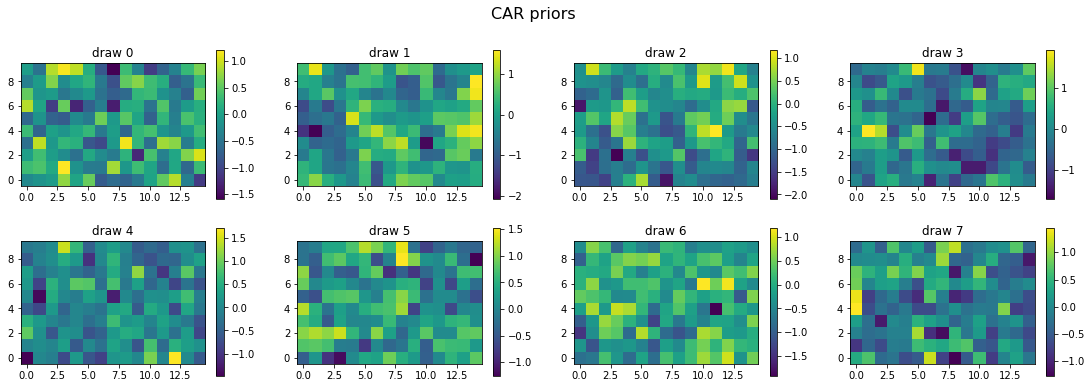

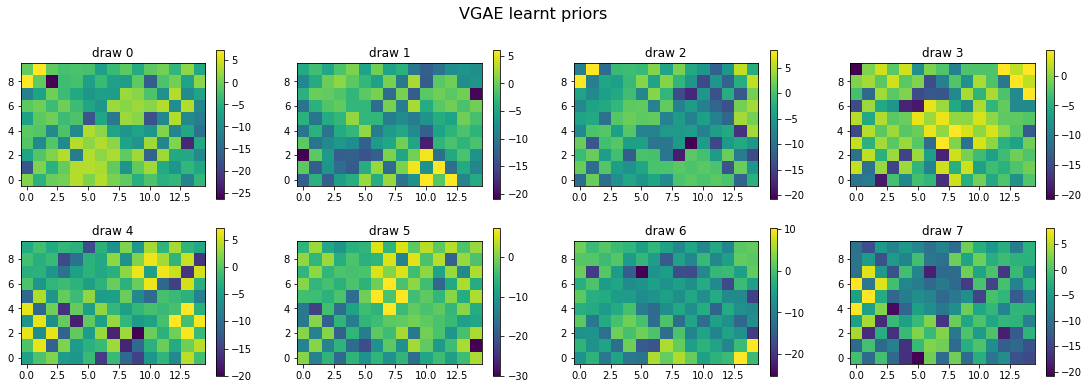

Args(loss_fn=<function compute_mse_loss at 0x15ace2d30>, num_nodes=150, batch_size=1, scale=20.0, hidden_dim=40, latent_dim=5, output_dim=1, learning_rate=0.0001, epochs=500000, eval_frequency=10000)


In [24]:
plotting.plot_samples(car_draws, rows=2, figsize=(19, 6), image_shape=IMAGE_SHAPE)
# plotting.plot_samples(vgae_draws, rows=2, figsize=(19, 6), title='VGAE learnt priors (min-max-bar scaled)', custom_min=-1.5, custom_max=1.5)
plotting.plot_samples(vgae_draws, rows=2, figsize=(19, 6), title=f'VGAE learnt priors', image_shape=IMAGE_SHAPE)
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x15ace2d30>, num_nodes=150, batch_size=1, scale=20.0, hidden_dim=40, latent_dim=5, output_dim=1, learning_rate=0.0001, epochs=500000, eval_frequency=10000)


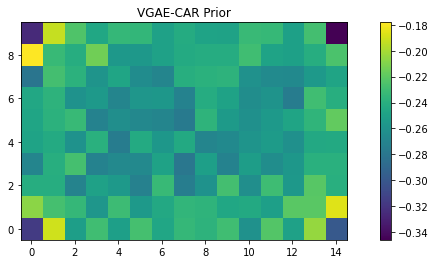

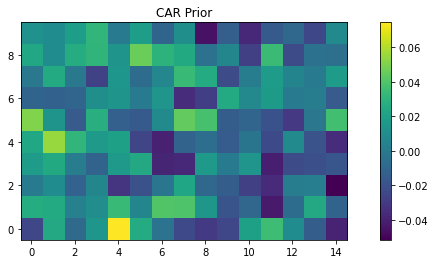

In [25]:
# VAE-CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_samples = 500
car_draws = Predictive(car_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car']
vgae_draws = Predictive(vgae_predictive_model, num_samples=num_samples)(rng_pred, CAR_ARGS)['car_vgae']
vgae_draws = scaler.inverse_transform(vgae_draws)

mean_prior_pred_vgae = np.mean(vgae_draws, axis=0)
hpdi_prior_pred_vgae = hpdi(vgae_draws, 0.89)
mean_prior_pred_car = np.mean(car_draws, axis=0)
hpdi_prior_pred_car = hpdi(car_draws, 0.89)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_vgae],
    titles=['VGAE-CAR Prior'],
    image_shape=IMAGE_SHAPE,
)
plotting.plot_images_from_arrays(
    arrays=[mean_prior_pred_car],
    titles=['CAR Prior'],
    image_shape=IMAGE_SHAPE,
);

### Inference on observed data with VGAE-CAR

In [26]:
def car_predictive_model_with_noise(
    args: CARArgs, y=None, alpha=None, noise=None) -> None:
    A = args.adj_matrix
    D = jnp.diag(args.degree_vector)

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha*A)
    
    car = numpyro.sample(
        'car', dist.MultivariateNormal(
            loc=jnp.zeros(num_regions), precision_matrix=Q))
    numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car, noise), obs=y)

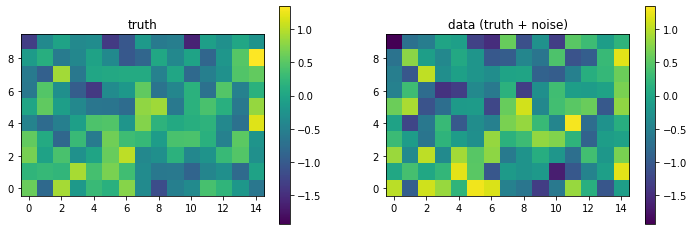

In [27]:
# Generate ground truth - fix alpha
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_predictive = Predictive(car_predictive_model_with_noise, num_samples=1)
car_preds = car_predictive(rng_pred, CAR_ARGS, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data],
    titles=['truth', 'data (truth + noise)'],
    image_shape=IMAGE_SHAPE
);

In [28]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference time
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(vgae_predictive_model, init_strategy=init_strategy)
mcmc = MCMC(
    kernel, 
    num_warmup=2000, 
    num_samples=2000,
)
mcmc.run(rng_mcmc, CAR_ARGS, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 4000/4000 [05:43<00:00, 11.65it/s, 1023 steps of size 3.53e-03. acc. prob=0.80]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  car_vgae[0]      0.83      0.28      0.82      0.41      1.31   1263.26      1.00
  car_vgae[1]     -0.70      0.45     -0.67     -1.40      0.04    270.68      1.00
  car_vgae[2]      0.81      0.33      0.78      0.25      1.27    863.97      1.00
  car_vgae[3]      1.02      0.33      1.05      0.56      1.58    503.98      1.00
  car_vgae[4]      0.44      0.33      0.48     -0.08      0.96    919.33      1.00
  car_vgae[5]      1.13      0.30      1.13      0.64      1.60   1679.09      1.00
  car_vgae[6]      0.86      0.40      0.84      0.24      1.53    635.13      1.00
  car_vgae[7]     -0.71      0.33     -0.71     -1.27     -0.21    933.44      1.00
  car_vgae[8]     -0.47      0.35     -0.44     -1.07      0.07    742.70      1.00
  car_vgae[9]     -1.21      0.44     -1.20     -1.94     -0.53     85.70      1.08
 car_vgae[10]     -0.56      0.31     -0.55     -1.04     -0.05   1106.38  

In [29]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car_vgae']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 346 s
Average ESS for all CAR effects : 784


Args(loss_fn=<function compute_mse_loss at 0x15ace2d30>, num_nodes=150, batch_size=1, scale=20.0, hidden_dim=40, latent_dim=5, output_dim=1, learning_rate=0.0001, epochs=500000, eval_frequency=10000)


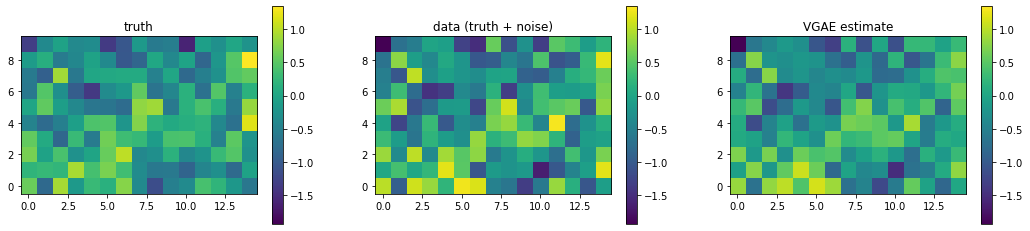

In [30]:
# Posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

posterior_predictions = Predictive(vgae_predictive_model, mcmc_samples)(rng_pred, CAR_ARGS)
post_obs = posterior_predictions['car_vgae']

mean_post_pred_vgae = np.mean(post_obs, axis=0)
bci_vgae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vgae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vgae = hpdi(post_obs, 0.9)

print(ARGS)
plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_vgae],
    titles=['truth', 'data (truth + noise)', 'VGAE estimate'],
    figsize=(18, 4),
    image_shape=IMAGE_SHAPE,
);

mse_vgae = 0.19795456528663635


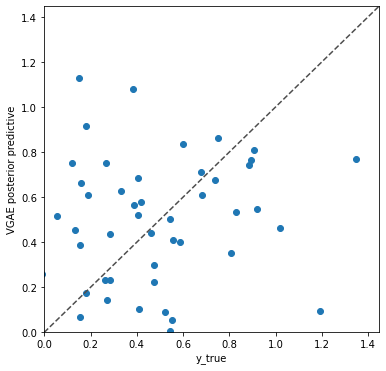

In [31]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_vgae,
    x_label='y_true', y_label='VGAE posterior predictive',
    figsize=(6, 6),
)

mse_vgae = np.mean((y_truth -  mean_post_pred_vgae)**2)
print(f'mse_vgae = {mse_vgae}')

In [32]:
# assert False

### Inference with CAR

In [33]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference - smooth data and infer alpha
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(car_predictive_model_with_noise, 
              init_strategy=init_strategy)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000
)
mcmc.run(rng_mcmc, CAR_ARGS, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [03:24<00:00, 14.70it/s, 15 steps of size 2.87e-01. acc. prob=0.90]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      0.72      0.13      0.73      0.49      0.92   1528.26      1.00
          car[0]      0.70      0.37      0.71      0.10      1.34   4645.38      1.00
          car[1]     -0.48      0.35     -0.48     -1.11      0.05   3080.83      1.00
          car[2]      0.75      0.35      0.76      0.17      1.33   3619.41      1.00
          car[3]      0.66      0.36      0.66      0.08      1.24   3711.01      1.00
          car[4]      0.34      0.35      0.34     -0.17      0.98   3549.83      1.00
          car[5]      0.96      0.35      0.97      0.37      1.50   3139.51      1.00
          car[6]      0.77      0.35      0.79      0.19      1.32   3339.61      1.00
          car[7]     -0.31      0.35     -0.32     -0.88      0.26   3951.70      1.00
          car[8]     -0.54      0.36     -0.54     -1.11      0.06   3167.06      1.00
          car[9]     -0.98      0.34     -

In [34]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 205 s
Average ESS for all CAR effects : 3398


In [35]:
# posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)
posterior_predictions = Predictive(
    car_predictive_model_with_noise, mcmc_samples)(rng_pred, CAR_ARGS, y=None)

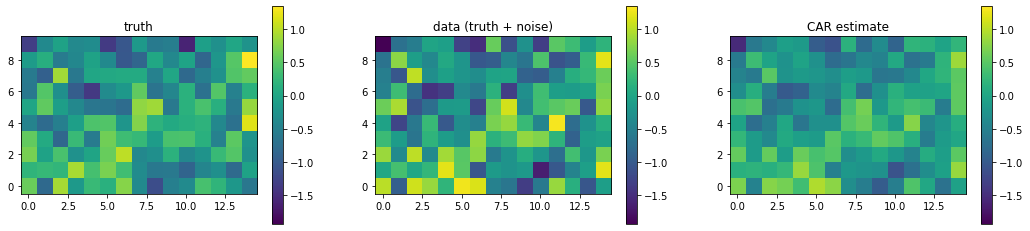

In [36]:
post_obs = posterior_predictions['car_samples']
mean_post_pred_car = np.mean(post_obs, axis=0)
bci_car_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_car_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_car = hpdi(post_obs, 0.9)

plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_car],
    titles=['truth', 'data (truth + noise)', 'CAR estimate'],
    figsize=(18, 4),
);

mse_car = 0.14492161571979523


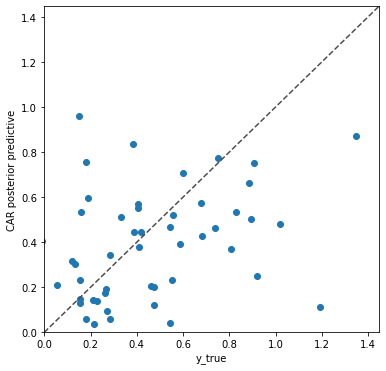

In [37]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_car,
    x_label='y_true', y_label='CAR posterior predictive',
    figsize=(6, 6),
)

mse_car = np.mean((y_truth -  mean_post_pred_car)**2)
print(f'mse_car = {mse_car}')

mse_vgae_v_car = 0.035521626472473145


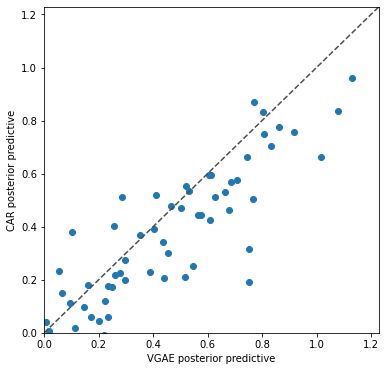

In [38]:
plotting.plot_compare_estimates(
    data_x=mean_post_pred_vgae, data_y=mean_post_pred_car,
    x_label='VGAE posterior predictive', y_label='CAR posterior predictive',
    figsize=(6, 6),
)

mse_vgae_v_car = np.mean((mean_post_pred_car -  mean_post_pred_vgae)**2)
print(f'mse_vgae_v_car = {mse_vgae_v_car}')

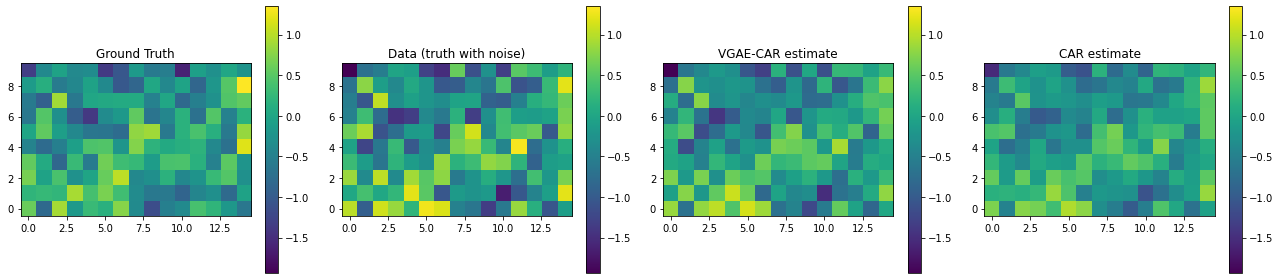

In [39]:
plotting.plot_images_from_arrays(
    arrays=[y_truth, y_data, mean_post_pred_vgae, mean_post_pred_car],
    titles=['Ground Truth', 'Data (truth with noise)', 'VGAE-CAR estimate', 'CAR estimate'],
    figsize=(18, 4)
)
plt.tight_layout()
plt.show()

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3237: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


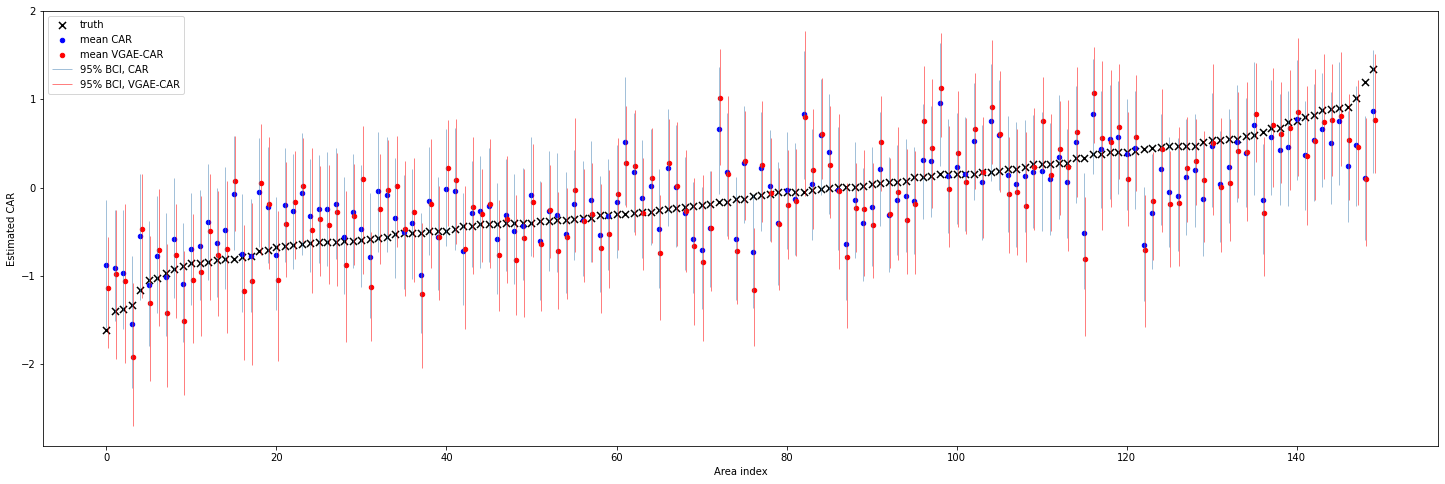

In [40]:
_, ax = plt.subplots(figsize=(25, 8))

idx = np.argsort(y_truth)

xs = np.arange(0, num_x*num_y)
ax.scatter(xs, y_truth[idx], label="truth", color='black', marker='x', s=50)
ax.scatter(xs, mean_post_pred_car[idx], label="mean CAR", color='blue', s=20)
ax.scatter(xs+0.15, mean_post_pred_vgae[idx], label="mean VGAE-CAR", color='red', s=20)
ax.vlines(xs, bci_car_2_5[idx], bci_car_97_5[idx], linestyle="-",  linewidth=0.5, color='steelblue', label='95% BCI, CAR')
ax.vlines(xs+0.15, bci_vgae_2_5[idx], bci_vgae_97_5[idx], linestyle="-", linewidth=0.5, color='red', label='95% BCI, VGAE-CAR')

ax.set_xlabel('Area index')
ax.set_ylabel('Estimated CAR')

plt.legend()
plt.show()

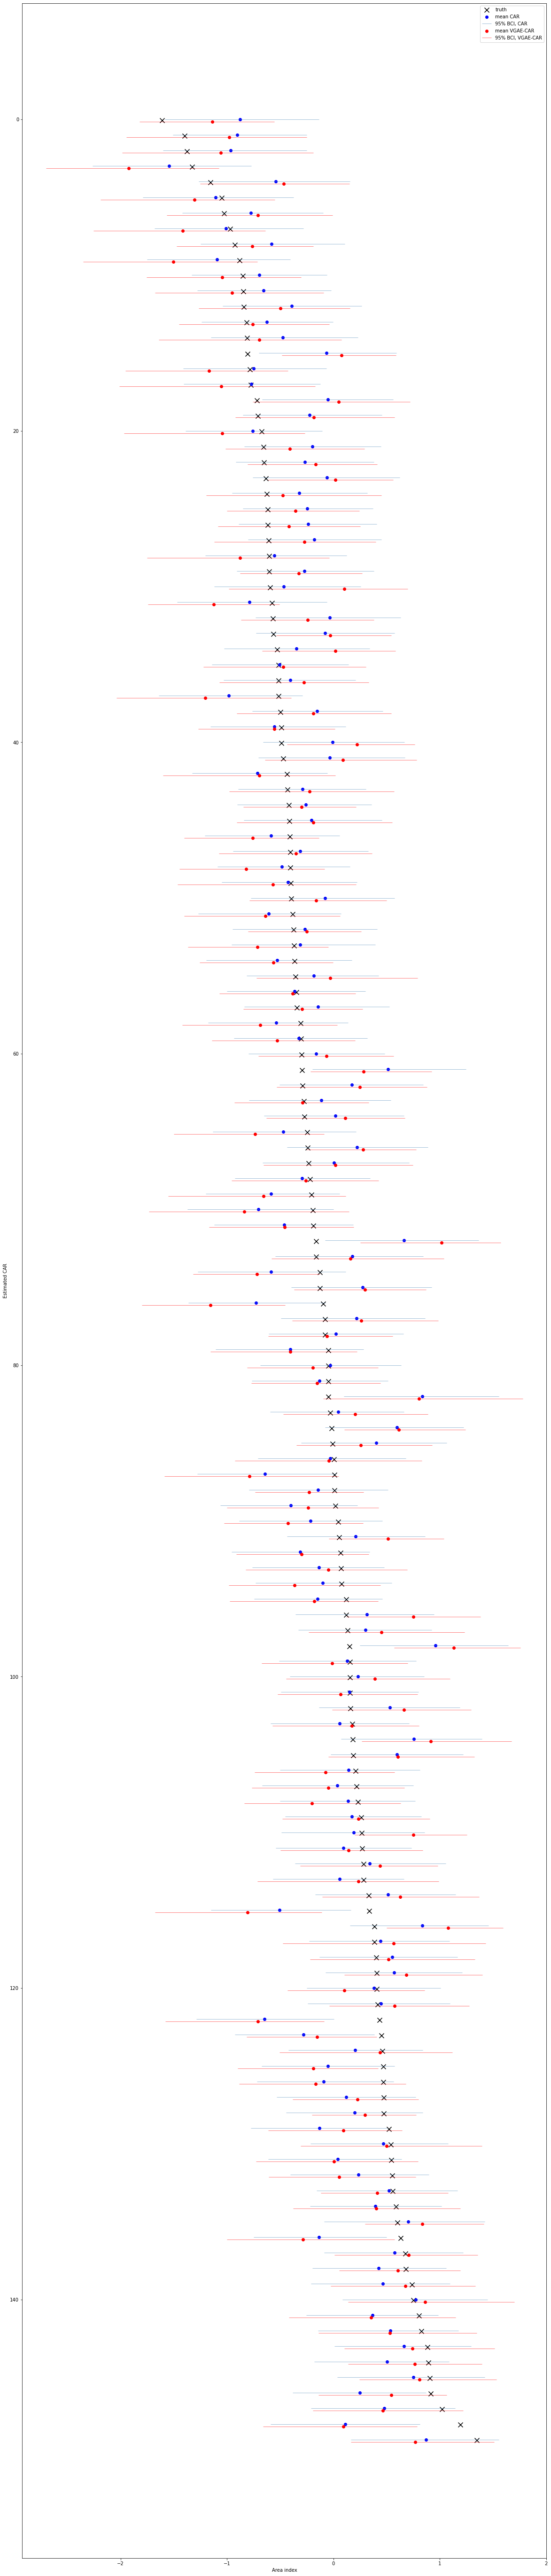

In [41]:
idx = np.argsort(y_truth)
xs = np.arange(0, num_x*num_y)

_, ax = plt.subplots(figsize=(20, 100))
ax.scatter(y_truth[idx], xs+0.05, label="truth", color='black', marker='x', s=100)

ax.scatter(mean_post_pred_car[idx], xs, label="mean CAR", color='blue')
ax.hlines(xs, bci_car_2_5[idx], bci_car_97_5[idx], linestyle="-",  linewidth=0.5, color='steelblue', label='95% BCI, CAR')

ax.scatter(mean_post_pred_vgae[idx], xs+0.15, label="mean VGAE-CAR", color='red')
ax.hlines(xs+0.15, bci_vgae_2_5[idx], bci_vgae_97_5[idx], linestyle="-", linewidth=0.5, color='red', label='95% BCI, VGAE-CAR')

ax.invert_yaxis()

ax.set_xlabel('Area index')
ax.set_ylabel('Estimated CAR')

plt.legend()
plt.show()